<a href="https://colab.research.google.com/github/sankarsh777/GDSC-AIML-SANKARSH-B241162ME/blob/main/intermediate_question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/Internetusage_Beginnertask03.csv')
print(df.head())
print(df.info())
print(df.describe())

    name           start_time   usage_time            IP                MAC  \
0  user1  2022-05-10 02:59:32  00:00:36:28  10.55.14.222  48:E7:DA:58:22:E9   
1  user1  2022-05-10 18:53:27  00:01:49:56   10.55.2.253  48:E7:DA:58:22:E9   
2  user1  2022-05-10 21:20:44  00:01:35:00   10.55.2.253  48:E7:DA:58:22:E9   
3  user1  2022-05-11 00:37:42  00:00:26:00   10.55.2.253  48:E7:DA:58:22:E9   
4  user1  2022-05-11 02:59:38  00:00:11:52   10.55.2.253  48:E7:DA:58:22:E9   

     upload   download  total_transfer seession_break_reason  
0  15861.76  333168.64       349030.40          Idle-Timeout  
1  16957.44  212152.32       229109.76          Idle-Timeout  
2   14080.0  195153.92       209233.92          Idle-Timeout  
3   5242.88    40806.4        46049.28          Idle-Timeout  
4   22067.2   10772.48        32839.68          Idle-Timeout  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 9 columns):
 #   Column                 Non-Null Coun

In [14]:
df['start_time'] = pd.to_datetime(df['start_time'])#getting hour
df['Hour'] = df['start_time'].dt.hour


In [15]:
peak_hour = df.groupby('Hour')['total_transfer'].sum().idxmax()
print(peak_hour)#solution for a part


18


In [16]:
#feature engineering for part b
vals = []
for i in df['usage_time']:
  x = i.split(':')
  y = int(x[0])*60 + int(x[1]) + int(x[2])/60 + int(x[3])/3600
  vals.append(y)
df.loc[:, "usage_time"] = vals
df['Session_intensity'] = df['total_transfer']/(df['usage_time']+10e-6)


In [17]:
df['Avg_transfer_rate'] = df['total_transfer']/(df['usage_time'] + 1)
df.head()

,name,start_time,usage_time,IP,MAC,upload,download,total_transfer,seession_break_reason,Hour,Session_intensity,Avg_transfer_rate
0,user1,2022-05-10 02:59:32,0.607778,10.55.14.222,48:E7:DA:58:22:E9,15861.76,333168.64,349030.40,Idle-Timeout,2,574263.604438,217088.707671
1,user1,2022-05-10 18:53:27,1.832222,10.55.2.253,48:E7:DA:58:22:E9,16957.44,212152.32,229109.76,Idle-Timeout,18,125044.062222,80893.991369
2,user1,2022-05-10 21:20:44,1.583333,10.55.2.253,48:E7:DA:58:22:E9,14080.0,195153.92,209233.92,Idle-Timeout,21,132146.904335,80993.775484
3,user1,2022-05-11 00:37:42,0.433333,10.55.2.253,48:E7:DA:58:22:E9,5242.88,40806.4,46049.28,Idle-Timeout,0,106265.116959,32127.404651
4,user1,2022-05-11 02:59:38,0.197778,10.55.2.253,48:E7:DA:58:22:E9,22067.2,10772.48,32839.68,Idle-Timeout,2,166034.930818,27417.172542


In [18]:
X = df[['Hour','Avg_transfer_rate','total_transfer','usage_time']]
y = df['Session_intensity']

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean)/X_std


np.random.seed(42)
idx = np.random.permutation(len(X))#randomly selecting rows for splitting into sets

split = int(0.8 * len(X))
train_idx, test_idx = idx[:split], idx[split:]

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [19]:
def to_numeric_array(X):#to fix errors that had occured while i was doing
    if isinstance(X, pd.DataFrame):
        X_conv = X.copy()
        for col in X_conv.columns:
            X_conv[col] = pd.to_numeric(X_conv[col], errors='coerce')
        return X_conv.values.astype(np.float64)
    if isinstance(X, pd.Series):
        return pd.to_numeric(X, errors='coerce').values.reshape(-1,1).astype(np.float64)

    return np.asarray(X, dtype=np.float64)


X_train = to_numeric_array(X_train)
y_train = to_numeric_array(y_train).reshape(-1, 1)
X_test = to_numeric_array(X_test)
y_test = to_numeric_array(y_test).reshape(-1, 1)

In [20]:
def train_model_adaptive(X, y,lr=1e-3,epochs=1000,batch_size=64,reg_lambda=0,clip_grad=5.0,momentum=0.9,lr_patience=5,lr_factor=0.5,early_stop_patience=15, min_lr=1e-7):

    m, n = X.shape

    w = np.zeros((n, 1), dtype=np.float64)
    b = 0.0
    v_w = np.zeros_like(w)
    v_b = 0.0

    rng = np.random.default_rng(42)#to split the set further


    best_loss = np.inf
    best_w, best_b = None, None
    no_improve = 0
    no_improve_lr = 0
    current_lr = float(lr)

    def loss_fn(y_true, y_pred, w):
        return np.mean((y_true - y_pred) ** 2) + reg_lambda * np.sum(w**2)


    for epoch in range(epochs):
        perm = rng.permutation(m)
        X_sh = X[perm]
        y_sh = y[perm]

        batch_losses = []
        max_dw_norm_epoch = 0.0

        for start in range(0, m, batch_size):#batchwise training to avoid error i encountered due to using everything together
            xb = X_sh[start:start+batch_size]
            yb = y_sh[start:start+batch_size]
            mb = xb.shape[0]

            y_pred = xb @ w + b


            dw = (1.0/mb) * (xb.T @ (y_pred - yb)) + 2.0 * reg_lambda * w
            db = (1.0/mb) * np.sum(y_pred - yb)


            dw_norm = np.linalg.norm(dw)
            max_dw_norm_epoch = max(max_dw_norm_epoch, dw_norm)
            if dw_norm > clip_grad:
                dw = dw * (clip_grad / (dw_norm + 1e-12))

            v_w = momentum * v_w + (1.0 - momentum) * dw#momentum is used to make sure it isnt oscilating but is decreasing
            v_b = momentum * v_b + (1.0 - momentum) * db

            w = w - current_lr * v_w
            b = b - current_lr * v_b

            batch_losses.append(loss_fn(yb, y_pred, w))

        epoch_loss = float(np.mean(batch_losses))

        if epoch_loss + 1e-12 < best_loss:
            best_loss = epoch_loss
            best_w = w.copy()
            best_b = float(b)
            no_improve = 0
            no_improve_lr = 0
        else:
            no_improve += 1
            no_improve_lr += 1


        if no_improve_lr >= lr_patience:
            new_lr = max(current_lr * lr_factor, min_lr)
            if new_lr < current_lr:
                current_lr = new_lr
            no_improve_lr = 0

        if no_improve >= early_stop_patience:#good to break because otherwise it will implode(error previously occured)
            w, b = best_w, best_b
            break

    if best_w is not None:
        w, b = best_w, best_b

    return w, float(b)



In [21]:
#testing diff models with r2 scores
lrs = [0.001,0.01,0.0001]
best_r2 = 0
w_final, b_final = np.zeros((X.shape[1],0)), 0
best_lr = 0
for i in lrs:
  w, b = train_model_adaptive(X_train, y_train, lr = i)
  y_pred = np.dot(X_test, w) + b
  ss_res = np.sum((y_test - y_pred)**2)
  ss_tot = np.sum((y_test - y_test.mean())**2)
  r2 = 1 - (ss_res / ss_tot)
  if r2>best_r2:
    best_r2 = r2
    w_final = w.copy()
    b_final = b
    best_lr = i
best_r2 = 0
best_lr_factor = 0
facs = [0.5,0.75,0.25]
for i in facs:
   w, b = train_model_adaptive(X_train, y_train, lr = best_lr, lr_factor = i)
   y_pred = np.dot(X_test, w) + b
   ss_res = np.sum((y_test - y_pred)**2)
   ss_tot = np.sum((y_test - y_test.mean())**2)
   r2 = 1 - (ss_res / ss_tot)
   if r2>best_r2:
    best_r2 = r2
    w_final = w.copy()
    b_final = b
    best_lr_factor = i
regs = [0,0.1,0.01,0.001,0.0001,1]
best_reg = 0
for i in regs:
   w, b= train_model_adaptive(X_train, y_train, lr = best_lr, lr_factor = best_lr_factor,reg_lambda=i)
   y_pred = np.dot(X_test, w) + b
   ss_res = np.sum((y_test - y_pred)**2)
   ss_tot = np.sum((y_test - y_test.mean())**2)
   r2 = 1 - (ss_res / ss_tot)
   if r2>best_r2:
    best_r2 = r2
    w_final = w.copy()
    b_final = b
    best_reg = i

print(best_r2)
print(best_lr)
print(best_lr_factor)
print(best_reg)
print("FINAL WEIGHTS")
print(w_final)
print(b_final)
#part c done

0.7583667769390777
0.01
0.5
0
FINAL WEIGHTS
[[-1.13489880e-04]
 [ 2.72181764e+00]
 [-2.65705654e-01]
 [-5.50612200e-05]]
54651.78208852398


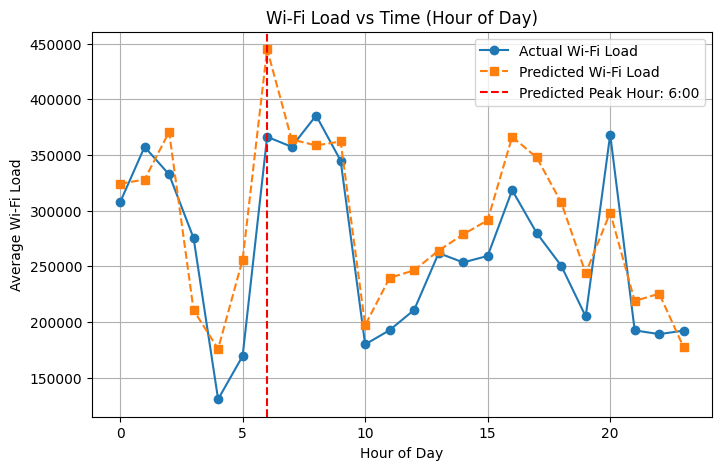

Predicted peak hour = 6
Actual peak hour = 8


In [22]:

#plots of part d
df_test = df.iloc[test_idx].copy()
df_test['Predicted_Load'] = y_pred.flatten()
act = df_test.groupby('Hour')['Session_intensity'].mean()
pred   = df_test.groupby('Hour')['Predicted_Load'].mean()
peak_hour = pred.idxmax()
act_peak = act.idxmax()

plt.figure(figsize=(8,5))

plt.plot(act.index, act.values,
         marker='o', label='Actual Wi-Fi Load')

plt.plot(pred.index,pred.values,
         marker='s', linestyle='--', label='Predicted Wi-Fi Load')

plt.axvline(x=peak_hour, color='red', linestyle='--',
            label=f'Predicted Peak Hour: {peak_hour}:00')


plt.xlabel("Hour of Day")
plt.ylabel("Average Wi-Fi Load")
plt.title("Wi-Fi Load vs Time (Hour of Day)")
plt.legend()
plt.grid(True)
plt.show()
print("Predicted peak hour =", peak_hour)
print("Actual peak hour =", act_peak)



In [23]:
#bonus question :)

best_hour = pred.idxmin()
best_load = pred.min()

print("Best time for downloads or binge-watching:", best_hour)
print("Average Wi-Fi load at this time:", best_load)

Best time for downloads or binge-watching: 4
Average Wi-Fi load at this time: 175786.57015762638
